#It can be seen that the  entity, which is calculated by measuring the frequency of two words appearing close to each other, behaves in different ways as the relationship between the three words changes. As a result, it becomes a good candidate for learning word vectors. 


#Classifying documents with embeddings

In [6]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from six.moves.urllib.request import urlretrieve
import zipfile
import numpy as np
import pandas as pd
import os
import time
import random
import tensorflow as tf
from matplotlib import pylab
from scipy.sparse import lil_matrix

#Downloading the data
This code downloads a BBC dataset consisting of news articles published by BBC.

In [7]:
url = 'http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip'


def download_data(url, data_dir):
    """Download a file if not present, and make sure it's the right size."""
    
    # Create the data directory if not exist
    os.makedirs(data_dir, exist_ok=True)

    file_path = os.path.join(data_dir, 'bbc-fulltext.zip')
    
    # If file doesnt exist, download
    if not os.path.exists(file_path):
        print('Downloading file...')
        filename, _ = urlretrieve(url, file_path)
    else:
        print("File already exists")
  
    extract_path = os.path.join(data_dir, 'bbc')
    
    # If data has not been extracted already, extract data
    if not os.path.exists(extract_path):        
        with zipfile.ZipFile(os.path.join(data_dir, 'bbc-fulltext.zip'), 'r') as zipf:
            zipf.extractall(data_dir)
    else:
        print("bbc-fulltext.zip has already been extracted")
    
download_data(url, 'data')

File already exists
bbc-fulltext.zip has already been extracted


In [8]:
def read_data(data_dir):
    
    # This will contain the full list of stories
    news_stories = []    
    filenames = []
    print("Reading files")
    
    i = 0 # Just used for printing progress
    for root, dirs, files in os.walk(data_dir):
        
        for fi, f in enumerate(files):
            
            # We don't read the readme file
            if 'readme' in f.lower():
                continue
            
            # Printing progress
            i += 1
            print("."*i, f, end='\r')
            
            # Open the file
            with open(os.path.join(root, f), encoding='latin-1') as text_file:
                
                story = []
                # Read all the lines
                for row in text_file:
                                        
                    story.append(row.strip())
                    
                # Create a single string with all the rows in the doc
                story = ' '.join(story)                        
                # Add that to the list
                news_stories.append(story)  
                filenames.append(os.path.join(root, f))
                
        print('', end='\r')
        
    print(f"\nDetected {len(news_stories)} stories")
    return news_stories, filenames
                
  
news_stories, filenames = read_data(os.path.join('data', 'bbc'))

# Printing some stats and sample data
print(f"{sum([len(story.split(' ')) for story in news_stories])} words found in the total news set")
print('Example words (start): ',news_stories[0][:50])
print('Example words (end): ',news_stories[-1][-50:])

Reading files
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

#Build a Tokenizer
Here we build a tokenizer, that performs simple preprocessing like,

Converting letters to lower case
Removing punctuation
and tokenize the strings based on a defined separator. Then each token is converted to an Integer ID, as computers understand numbers, not strings. In the background, the tokenizer builds a word to index dictionary, that defines a unique ID for each word in the vocabulary.

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

n_vocab = 15000 + 1
tokenizer = Tokenizer(
    num_words=n_vocab - 1,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True, split=' ', oov_token=''
)

tokenizer.fit_on_texts(news_stories)
print("Data fitted on the tokenizer")


Data fitted on the tokenizer


#Generating the word co-occurrence matrix
Why GloVe shine above context window based method is that it employs global statistics of the corpus in to the model (according to authors). This is done by using information from the word co-occurance matrix to optimize the word vectors. Basically, the  entry of the co-occurance matrix says how frequent word  to appear near .

We also use an optional weighting mechanishm to give more weight to words close together than to the ones further-apart (from experiments section of the paper).

Note: When generating the matrix for the first time, it will take a significant amount of time to run



In [10]:
from scipy.sparse import save_npz, load_npz

def generate_cooc_matrix(text, tokenizer, window_size, n_vocab, use_weighting=True):
    
    # Convert list of text to list of list of word IDs
    sequences = tokenizer.texts_to_sequences(text)
    
    # A sparse matrix to retain co-occurrences of words
    cooc_mat = lil_matrix((n_vocab, n_vocab), dtype=np.float32)
    
    # Go through each sequence one by one
    for si, sequence in enumerate(sequences):
        
        # Printing the progress
        if (si+1)%100==0:
            print('.'*((si+1)//100), f"{si+1}/{len(sequences)}", end='\r')
        
        # For each target word,
        for i, wi in zip(np.arange(window_size, len(sequence)-window_size), sequence[window_size:-window_size]):
            
            # Get the context window word IDs
            context_window = sequence[i-window_size: i+window_size+1]            
            
            # The weight for the words in the context window (except target word) will be 1
            window_weights = np.ones(shape=(window_size*2 + 1,), dtype=np.float32)
            window_weights[window_size] = 0.0

            if use_weighting:
                # If weighting is used, penalize context words based on distance to target word
                distances = np.abs(np.arange(-window_size, window_size+1))
                distances[window_size] = 1.0
                # Update the sparse matrix
                cooc_mat[wi, context_window] += window_weights/distances
            else:
                # Update the sparse matrix
                cooc_mat[wi, context_window] += window_weights
    
    print("\n")
    
    return cooc_mat
generate_cooc = False


# Generate the matrix
if generate_cooc:
    t1 = time.time()
    cooc_mat = generate_cooc_matrix(news_stories, tokenizer, 1, n_vocab, True)
    t2 = time.time()
    print(f"It took {t2-t1} seconds to generate the co-occurrence matrix")
    
    save_npz(os.path.join('data','cooc_mat.npz'), cooc_mat.tocsr())
# Load the matrix from disk
else:
    try:
        cooc_mat = load_npz(os.path.join('data','cooc_mat.npz')).tolil()
        print(f"Cooc matrix of type {type(cooc_mat).__name__} was loaded from disk")
    except FileNotFoundError as ex:
        raise FileNotFoundError(
            "Could not find the co-occurrence matrix on the disk. Did you generate the matrix by setting generate_cooc=True?"
        )

Cooc matrix of type lil_matrix was loaded from disk


([<matplotlib.axis.XTick at 0x7ff91588b820>,
 [Text(0, 0, 'those'),
  Text(0, 0, 'complex'),
  Text(0, 0, 'about'),
  Text(0, 0, 'it'),
  Text(0, 0, 'working'),
  Text(0, 0, 'only'),
  Text(0, 0, 'taxes'),
  Text(0, 0, 'were'),
  Text(0, 0, 'as'),
  Text(0, 0, 'box'),
  Text(0, 0, 'or'),
  Text(0, 0, 'is'),
  Text(0, 0, 'will'),
  Text(0, 0, 'more'),
  Text(0, 0, 'against'),
  Text(0, 0, 'have'),
  Text(0, 0, 'are'),
  Text(0, 0, ''),
  Text(0, 0, 'who'),
  Text(0, 0, 'in'),
  Text(0, 0, 'to'),
  Text(0, 0, 'the'),
  Text(0, 0, 'of'),
  Text(0, 0, 'for'),
  Text(0, 0, 'and')])

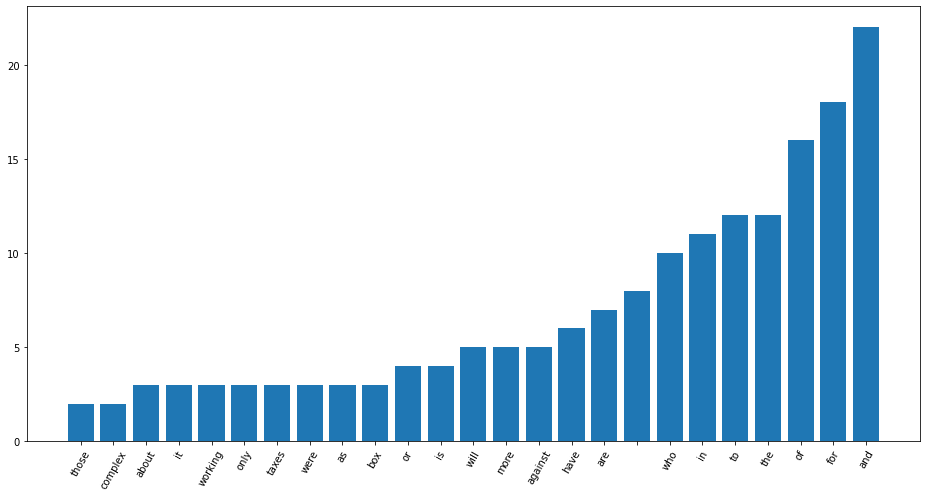

In [11]:

import matplotlib.pyplot as plt

word = 'sport'
assert word in tokenizer.word_index, f"Word {word} is not in the tokenizer"
assert tokenizer.word_index[word] <= n_vocab, f"The word {word} is an out of vocabuary word. Please try something else"

# Get the vector of co-occurrences for a given word 
cooc_vec = np.array(cooc_mat.getrow(tokenizer.word_index[word]).todense()).ravel()
# Get indices of words with maximum value
max_ind = np.argsort(cooc_vec)[-25:]

# Plot the words and values
plt.figure(figsize=(16,8))
plt.bar(np.arange(0, 25), cooc_vec[max_ind])
plt.xticks(ticks=np.arange(0, 25), labels=[tokenizer.index_word[i] for i in max_ind], rotation=60)

#GloVe Algorithm
Defining Hyperparameters
Here we define several hyperparameters including batch_size (amount of samples in a single batch) embedding_size (size of embedding vectors) window_size (context window size).


In [12]:
batch_size = 4096 # Data points in a single batch

embedding_size = 128 # Dimension of the embedding vector.

window_size=1 # We use a window size of 1 on either side of target word

epochs = 5 # Number of epochs to train for

# We pick a random validation set to sample nearest neighbors
valid_size = 16 # Random set of words to evaluate similarity on.
# We sample valid datapoints randomly from a large window without always being deterministic
valid_window = 250

# When selecting valid examples, we select some of the most frequent words as well as
# some moderately rare words as well
np.random.seed(54321)
random.seed(54321)

valid_term_ids = np.array(random.sample(range(valid_window), valid_size))
valid_term_ids = np.append(
    valid_term_ids, random.sample(range(1000, 1000+valid_window), valid_size),
    axis=0
)

In [13]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Embedding, Dot, Add
from tensorflow.keras.models import Model

K.clear_session()

# Define two input layers for context and target words
word_i = Input(shape=())
word_j = Input(shape=())

# Each context and target has their own embeddings (weights and biases)

# Embedding weights
embeddings_i = Embedding(n_vocab, embedding_size, name='target_embedding')(word_i)
embeddings_j = Embedding(n_vocab, embedding_size, name='context_embedding')(word_j)

# Embedding biases
b_i = Embedding(n_vocab, 1, name='target_embedding_bias')(word_i)    
b_j = Embedding(n_vocab, 1, name='context_embedding_bias')(word_j)

# Compute the dot product between embedding vectors (i.e. w_i.w_j)
ij_dot = Dot(axes=-1)([embeddings_i,embeddings_j])

# Add the biases (i.e. w_i.w_j + b_i + b_j )
pred = Add()([ij_dot, b_i, b_j])

# The final model
glove_model = Model(inputs=[word_i, word_j],outputs=pred, name='glove_model')

# Glove has a specific loss function with a sound mathematical underpinning
# It is a form of mean squared error
glove_model.compile(loss="mse", optimizer = 'adam')

glove_model.summary()

Model: "glove_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None,)]            0           []                               
                                                                                                  
 target_embedding (Embedding)   (None, 128)          1920128     ['input_1[0][0]']                
                                                                                                  
 context_embedding (Embedding)  (None, 128)          1920128     ['input_2[0][0]']                
                                                                                        

#Generating data for GloVe model
The Glove model we implemented,

Takes two inputs; context words and target words
Computes the mean squared error as, 
 for the model output 
Use sample weights returned by 
Therefore, in the data generator we return a tuple of,

(inputs, targets, sample weights)

which translates to,

((batch of target words, batch or context words), batch of log(X_{ij}), batch of f(X_{ij})

In [14]:
news_sequences = tokenizer.texts_to_sequences(news_stories)

In [15]:
def glove_data_generator(
    sequences, window_size, batch_size, vocab_size, cooccurrence_matrix, x_max=100.0, alpha=0.75, seed=None
):
    """ Generate batches of inputs and targets for GloVe """
    
    # Shuffle the data so that, every epoch, the order of data is different
    rand_sequence_ids = np.arange(len(sequences))                    
    np.random.shuffle(rand_sequence_ids)

    # We will use a sampling table to make sure, we don't oversample stopwords
    sampling_table = tf.keras.preprocessing.sequence.make_sampling_table(vocab_size)
    
    # For each story/article
    for si in rand_sequence_ids:
        
        # Generate positive skip-grams while using sub-sampling 
        positive_skip_grams, _ = tf.keras.preprocessing.sequence.skipgrams(
            sequences[si], 
            vocabulary_size=vocab_size, 
            window_size=window_size, 
            negative_samples=0.0, 
            shuffle=False,   
            sampling_table=sampling_table,
            seed=seed
        )
        
        # Take targets and context words separately
        targets, context = zip(*positive_skip_grams)
        targets, context = np.array(targets).ravel(), np.array(context).ravel()
        
        
        x_ij = np.array(cooccurrence_matrix[targets, context].toarray()).ravel()
        
        # Compute log - Introducing an additive shift to make sure we don't compute log(0)
        log_x_ij = np.log(x_ij + 1)
        
        # Sample weights 
        # if x < x_max => (x/x_max)**alpha / else => 1        
        sample_weights = np.where(x_ij < x_max, (x_ij/x_max)**alpha, 1)
        
        # If seed is not provided generate a random one
        if not seed:
            seed = random.randint(0, 10e6)
        
        # Shuffle data
        np.random.seed(seed)
        np.random.shuffle(context)
        np.random.seed(seed)
        np.random.shuffle(targets)
        np.random.seed(seed)
        np.random.shuffle(log_x_ij)
        np.random.seed(seed)
        np.random.shuffle(sample_weights)
        
        # Generate a batch or data in the format 
        # ((target words, context words), log(X_ij) <- true targets, f(X_ij) <- sample weights)
        for eg_id_start in range(0, context.shape[0], batch_size):            
            yield (
                targets[eg_id_start: min(eg_id_start+batch_size, targets.shape[0])], 
                context[eg_id_start: min(eg_id_start+batch_size, context.shape[0])]
            ), log_x_ij[eg_id_start: min(eg_id_start+batch_size, x_ij.shape[0])], \
            sample_weights[eg_id_start: min(eg_id_start+batch_size, sample_weights.shape[0])]


# Generate some data
news_glove_data_gen = glove_data_generator(
    news_sequences, 2, 10, n_vocab, cooc_mat
)

for x, y, z in news_glove_data_gen:
    print(x)
    print(y)
    print(z)
    break

(array([7676,  141, 4703, 9199, 9199,  129, 9199, 1016, 7833, 4703]), array([ 146,  769,  769,    2, 1698,   24, 3728,   54,    3,  770]))
[0.        0.        0.        0.        0.        2.3025851 0.
 0.        0.        0.       ]
[0.         0.         0.         0.         0.         0.16431677
 0.         0.         0.         0.        ]


#Training the model
Here we train the GloVe model we defined above. We train for epochs and at the end of each epoch, we compute word similarities on a set of chosen validation words (valid_term_ids). Similar to in Chapter 3, we use a Keras callback to compute the most similar words.

Calculating Word Similarities
We calculate the similarity between two given words in terms of the cosine distance. To do this efficiently we use matrix operations to do so, as shown below. Furthermore, we define the computations as a callback, which will automatically run at the end of an epoch during model training.



In [16]:
class ValidationCallback(tf.keras.callbacks.Callback):
    
    def __init__(self, valid_term_ids, model_with_embeddings, tokenizer):
        
        self.valid_term_ids = valid_term_ids
        self.model_with_embeddings = model_with_embeddings
        self.tokenizer = tokenizer
        
        super().__init__()
        
    def on_epoch_end(self, epoch, logs=None):
        """ Validation logic """
                
        # We will use context embeddings to get the most similar words
        # Other strategies include: using target embeddings, mean embeddings after avaraging context/target
        embedding_weights = self.model_with_embeddings.get_layer("context_embedding").get_weights()[0]
        normalized_embeddings = embedding_weights / np.sqrt(np.sum(embedding_weights**2, axis=1, keepdims=True))
        
        # Get the embeddings corresponding to valid_term_ids
        valid_embeddings = normalized_embeddings[self.valid_term_ids, :]
        
        # Compute the similarity between valid_term_ids and all the embeddings
        # V x d (d x D) => V x D
        top_k = 5 # Top k items will be displayed
        similarity = np.dot(valid_embeddings, normalized_embeddings.T)
        
        # Invert similarity matrix to negative
        # Ignore the first one because that would be the same word as the probe word
        similarity_top_k = np.argsort(-similarity, axis=1)[:, 1: top_k+1]
                
        # Print the output
        for i, term_id in enumerate(valid_term_ids):
            
            similar_word_str = ', '.join([self.tokenizer.index_word[j] for j in similarity_top_k[i, :] if j > 1])
            print(f"{self.tokenizer.index_word[term_id]}: {similar_word_str}")
        
        print('\n')

In [17]:
glove_validation_callback = ValidationCallback(valid_term_ids, glove_model, tokenizer)

# Train the model for several epochs
for ei in range(epochs):
    
    print(f"Epoch: {ei+1}/{epochs} started")
    
    news_glove_data_gen = glove_data_generator(
        news_sequences, window_size, batch_size, n_vocab, cooc_mat
    )
    
    glove_model.fit(
        news_glove_data_gen, epochs=1, 
        callbacks=glove_validation_callback,        
    )

Epoch: 1/5 started
   2225/Unknown - 100s 45ms/step - loss: 0.3994election: secretary, director, the, time, quarter
months: wear, scotland, users, people, pay
with: for, from, first, by, new
you: they, we, being, going, set
were: are, if, where, because, had
win: number, out, service, us
those: people, technology, now, plans
music: content, any, other, all, us
also: now, which, it, they, there
around: number, down, by, or, other
best: award, former, after, uk, industry
him: them, all, their, any, his
too: so, award, very, after, best
into: by, against, set, move, behind
through: for, by, from, first, over
mr: tony, insisted, james, contract, has
example: blogsphere, birkett, parkinson's, construed, embrace
concern: match, sunday, them, labour, us
trading: episode, madden, finalised, swank, abolishing
light: five, how, sent, after, now
fast: by, new, or, set
north: number, in, from, or, top
person: sideways, pelted, maroon, operator, 180bn
states: buckingham, cardinal, romanian, o'brien

#Saving the embeddings
We save the learned embeddings to the disk

In [20]:
def save_embeddings(model, tokenizer, vocab_size, save_dir):
    
    # Create the directory if doesn't exist
    os.makedirs(save_dir, exist_ok=True)
    
    # Get the words sorted according to their ID from the tokenizer
    _, words_sorted = zip(*sorted(list(tokenizer.index_word.items()), key=lambda x: x[0])[:vocab_size-1])
    # Add one word in front to represent the reserved ID (0)
    words_sorted = [None] + list(words_sorted)
    
    # Create a new array by concatenating embeddings and bias
    
    context_embedding_weights = model.get_layer("context_embedding").get_weights()[0]
    context_embedding_bias = model.get_layer("context_embedding_bias").get_weights()[0]
    context_embedding = np.concatenate([context_embedding_weights, context_embedding_bias], axis=1)
    
    target_embedding_weights = model.get_layer("target_embedding").get_weights()[0]
    target_embedding_bias = model.get_layer("target_embedding_bias").get_weights()[0]
    target_embedding = np.concatenate([target_embedding_weights, target_embedding_bias], axis=1)
    
    # Save the array as a Pandas DataFrames
    pd.DataFrame(
        context_embedding, 
        index = words_sorted
    ).to_pickle(os.path.join(save_dir, "context_embedding_and_bias.pkl"))
    
    pd.DataFrame(
        target_embedding, 
        index = words_sorted
    ).to_pickle(os.path.join(save_dir, "target_embedding_and_bias.pkl"))

    
save_embeddings(glove_model, tokenizer, n_vocab, save_dir='glove_embeddings')

#ELMo – Taking ambiguities out of word vectors

Therefore, it is more sensible to provide embeddings for a word while preserving and leveraging the context around it. This is exactly what ELMo is striving for.

 ELMo takes in a sequence, as opposed to a single token, and provides contextualized representations for each token in the sequence. 
 

In [19]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import numpy as np
import os
import time
import random
import tensorflow as tf

%env TF_FORCE_GPU_ALLOW_GROWTH=true
# Making sure we cache the models and are not downloaded all the time
%env TFHUB_CACHE_DIR=./tfhub_modules

env: TF_FORCE_GPU_ALLOW_GROWTH=true
env: TFHUB_CACHE_DIR=./tfhub_modules


#Using pre-trained ELMo Model
Downloading the ELMo Model from TFHub

Note that we are providing two arguments, signature and signature_outputs_as_dict:

signature (str) – Can be default or tokens. The default signature accepts a list of strings, where each string will be converted to a list of tokens internally. The tokens signature takes in inputs as dictionary having two keys. 
Namely, tokens (a list of list of tokens. Each list of tokens is a single phrase/sentence and includes padding tokens to bring them to a fixed length) and “sequence_len" (the length of each list of tokens, to determine the padding length).
signature_outputs_as_dict (bool) – When set to true, it will return all the outputs defined in the provided signature.

In [21]:
import tensorflow_hub as hub
import tensorflow.keras.backend as K

# Remove any ongoing sessions
K.clear_session()

# Download the ELMo model and save to disk
elmo_layer = hub.KerasLayer("https://tfhub.dev/google/elmo/3", signature="tokens",signature_outputs_as_dict=True)


#Formatting the input for ELMo
ELMo expects the inputs to be in a specific format. Here we write a function to get the input in that format.

In [22]:
def format_text_for_elmo(texts, lower=True, split=" ", max_len=None):
    
    """ Formats a given text for the ELMo model (takes in a list of strings) """
        
    token_inputs = [] # Maintains individual tokens
    token_lengths = [] # Maintains the length of each sequence
    
    max_len_inferred = 0 # We keep a variable to matain the max length of the input
    
    # Go through each text (string)
    for text in texts:    
        
        # Process the text and get a list of tokens
        tokens = tf.keras.preprocessing.text.text_to_word_sequence(text, lower=lower, split=split)
        
        # Add the tokens 
        token_inputs.append(tokens)                   
        
        # Compute the max length for the collection of sequences
        if len(tokens)>max_len_inferred:
            max_len_inferred = len(tokens)
    
    # It's important to make sure the maximum token length is only as large as the longest input in the sequence
    # You can't have arbitrarily large length as the maximum length. Otherwise, you'll get this error.
    #InvalidArgumentError:  Incompatible shapes: [2,6,1] vs. [2,10,1024]
    #    [[node mul (defined at .../python3.6/site-packages/tensorflow_hub/module_v2.py:106) ]] [Op:__inference_pruned_3391]
    
    # Here we make sure max_len is only as large as the longest input
    if max_len and max_len_inferred < max_len:
        max_len = max_len_inferred
    if not max_len:
        max_len = max_len_inferred
    
    # Go through each token sequence and modify sequences to have same length
    for i, token_seq in enumerate(token_inputs):
        
        token_lengths.append(min(len(token_seq), max_len))
        
        # If the maximum length is less than input length, truncate
        if max_len < len(token_seq):
            token_seq = token_seq[:max_len]            
        # If the maximum length is greater than or equal to input length, add padding as needed
        else:            
            token_seq = token_seq+[""]*(max_len-len(token_seq))
                
        assert len(token_seq)==max_len
        
        token_inputs[i] = token_seq
    
    # Return the final output
    return {
        "tokens": tf.constant(token_inputs), 
        "sequence_len": tf.constant(token_lengths)
    }


print(format_text_for_elmo(["the cat sat on the mat", "the mat sat"], max_len=10))

{'tokens': <tf.Tensor: shape=(2, 6), dtype=string, numpy=
array([[b'the', b'cat', b'sat', b'on', b'the', b'mat'],
       [b'the', b'mat', b'sat', b'', b'', b'']], dtype=object)>, 'sequence_len': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([6, 3], dtype=int32)>}


In [23]:
# Titles of 001.txt - 005.txt in bbc/business
elmo_inputs = format_text_for_elmo([
    "Ad sales boost Time Warner profit",
    "Dollar gains on Greenspan speech",
    "Yukos unit buyer faces loan claim",
    "High fuel prices hit BA's profits",
    "Pernod takeover talk lifts Domecq"
])

# Get the result from ELMo
elmo_result = elmo_layer(elmo_inputs)

# Print the result
for k,v in elmo_result.items():    
    print(f"Tensor under key={k} is a {v.shape} shaped Tensor")


Tensor under key=word_emb is a (5, 6, 512) shaped Tensor
Tensor under key=default is a (5, 1024) shaped Tensor
Tensor under key=elmo is a (5, 6, 1024) shaped Tensor
Tensor under key=lstm_outputs2 is a (5, 6, 1024) shaped Tensor
Tensor under key=lstm_outputs1 is a (5, 6, 1024) shaped Tensor
Tensor under key=sequence_len is a (5,) shaped Tensor


In [24]:
url = 'http://mlg.ucd.ie/files/datasets/bbc-fulltext.zip'


def download_data(url, data_dir):
    """Download a file if not present, and make sure it's the right size."""
    
    # Create the data directory if not exist
    os.makedirs(data_dir, exist_ok=True)

    file_path = os.path.join(data_dir, 'bbc-fulltext.zip')
    
    # If file doesnt exist, download
    if not os.path.exists(file_path):
        print('Downloading file...')
        filename, _ = urlretrieve(url, file_path)
    else:
        print("File already exists")
  
    extract_path = os.path.join(data_dir, 'bbc')
    
    # If data has not been extracted already, extract data
    if not os.path.exists(extract_path):        
        with zipfile.ZipFile(os.path.join(data_dir, 'bbc-fulltext.zip'), 'r') as zipf:
            zipf.extractall(data_dir)
    else:
        print("bbc-fulltext.zip has already been extracted")
    
download_data(url, 'data')


File already exists
bbc-fulltext.zip has already been extracted


In [25]:
def read_data(data_dir):
    
    # This will contain the full list of stories
    news_stories = []    
    filenames = []
    print("Reading files")
    
    i = 0 # Just used for printing progress
    for root, dirs, files in os.walk(data_dir):
        
        for fi, f in enumerate(files):
            
            # We don't read the readme file
            if 'README' in f:
                continue
            
            # Printing progress
            i += 1
            print("."*i, f, end='\r')
            
            # Open the file
            with open(os.path.join(root, f), encoding='latin-1') as text_file:
                
                story = []
                # Read all the lines
                for row in text_file:
                                        
                    story.append(row.strip())
                    
                # Create a single string with all the rows in the doc
                story = ' '.join(story)                        
                # Add that to the list
                news_stories.append(story)  
                filenames.append(os.path.join(root, f))
                
        print('', end='\r')
        
    print(f"\nDetected {len(news_stories)} stories")
    return news_stories, filenames
                
  
news_stories, filenames = read_data(os.path.join('data', 'bbc'))

# Printing some stats and sample data
print(f"{sum([len(story.split(' ')) for story in news_stories])} words found in the total news set")
print('Example words (start): ',news_stories[0][:50])
print('Example words (end): ',news_stories[-1][-50:])


Reading files
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [26]:
import pandas as pd

pd.Series([len(x.split(' ')) for x in news_stories]).describe(percentiles=[0.05, 0.95])

count    2225.000000
mean      388.837303
std       241.484273
min        91.000000
5%        164.200000
50%       336.000000
95%       736.800000
max      4489.000000
dtype: float64

#Compute the document embeddings
ELMo provides several outputs as the output (in the form of a dictionary). The most important output is in a key called default which is the averaged vector resulting from vectors produced for all the tokens in the input. We will use this as the document embedding.



In [ ]:
batch_size = 4

news_elmo_embeddings = []

# Go through batches
for i in range(0, len(news_stories), batch_size):
    
    # Print progress
    print('.', end='')
    # Format ELMo inputs
    elmo_inputs = format_text_for_elmo(news_stories[i: min(i+batch_size, len(news_stories))], max_len=768)    
    # Get the result stored in default
    elmo_result = elmo_layer(elmo_inputs)["default"]
    # Add that to a list
    news_elmo_embeddings.append(elmo_result)

# Create an array
news_elmo_embeddings = np.concatenate(news_elmo_embeddings, axis=0)    


.............................................................................................................................................................................................................................................................................................................................................................................................................

In [ ]:
# Save the data to disk
os.makedirs('elmo_embeddings', exist_ok=True)

pd.DataFrame(
    news_elmo_embeddings, index=filenames
).to_pickle(
    os.path.join('elmo_embeddings', 'elmo_embeddings.pkl')
)


In [ ]:

pd.read_pickle(os.path.join('elmo_embeddings', 'elmo_embeddings.pkl'))